In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [17]:
# calibration: unit for money is thousand per year, 2018 Chinese data is collected, suppose wage dist is log normal and independent
interest_rate=0.0435  #the 1-year interest rate in 2018 is 4.35%
beta=1/(1+interest_rate)
c=int(10.731)  # rural disposable income is 10731 in 2018,assuming total income is 10731

In [18]:
# simulate wage dist for old industry
urban_disposable_income_w=int(67.990)  #in 2018, in BJ, urban disposable income is 67990
w_min,w_max=int(25.440),200  #in 2018, minimun wage in BJ was 2120 per month so w_min is 254.4 (21.2*12) but minimun wage is not disposable income
w_num=w_max-w_min+1  
w_vec=np.linspace(w_min,w_max,w_num)

#obtain the empirical log normal distribution
dist_mean_w,dist_num=np.round(np.log(urban_disposable_income_w),1),1000000
dist_std_w=np.round((dist_mean_w-np.log(w_min))/3,1) # suppose the lower bound is w_min, based on 3 sigma rule, need further investigation
dist_w=np.random.lognormal(dist_mean_w,dist_std_w,dist_num)

#obtain the pdf of old industry
w_pdf=np.zeros(w_num)
w_pdf[0]=np.sum(w_vec[0]>=dist_w)  #lognormal 是正无穷的，然而wage有下限，因此把下限的pdf设为小于下限的概率之和
for ii in range(1,w_num-1):
    w_pdf[ii]=np.sum(np.logical_and(w_vec[ii-1]<dist_w,dist_w<=w_vec[ii]))
w_pdf[-1]=np.sum(w_vec[-2]<dist_w)  #lognormal 是正无穷的，然而wage有上限，因此把上限的pdf设为 大于上限的概率之和
w_pdf=w_pdf/dist_num

print('the sum of pdf is %.2f'%np.sum(w_pdf))  #to check whether pdf sum up to one

the sum of pdf is 1.00


In [19]:
# simulate wage dist for new industry
factor=1.5
urban_disposable_income_z=int(urban_disposable_income_w*factor)
z_min,z_max=int(w_min*factor),300
z_num=z_max-z_min+1  
z_vec=np.linspace(z_min,z_max,z_num)

#obtain the empirical log normal distribution
dist_mean_z,dist_num=np.round(np.log(urban_disposable_income_z),1),1000000
dist_std_z=np.round((dist_mean_z-np.log(z_min))/3,1) # suppose the lower bound is z_min, based on 3 sigma rule, need further investigation
dist_z=np.random.lognormal(dist_mean_z,dist_std_z,dist_num)

#obtain the pdf of new industry
z_pdf=np.zeros(z_num)
z_pdf[0]=np.sum(z_vec[0]>=dist_z)  #lognormal 是正无穷的，然而wage有下限，因此把下限的pdf设为小于下限的概率之和
for ii in range(1,z_num-1):
    z_pdf[ii]=np.sum(np.logical_and(z_vec[ii-1]<dist_z,dist_z<=z_vec[ii]))
z_pdf[-1]=np.sum(z_vec[-2]<dist_z)  #lognormal 是正无穷的，然而wage有上限，因此把上限的pdf设为 大于上限的概率之和
z_pdf=z_pdf/dist_num

print('the sum of pdf is %.2f'%np.sum(z_pdf))  #to check whether pdf sum up to one

the sum of pdf is 1.00


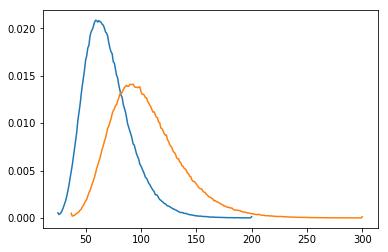

The average of w dist is 69747. The average of z dist is 104090


In [20]:
# check the dist
plt.plot(w_vec,w_pdf)
plt.plot(z_vec,z_pdf)
plt.show()

print('The average of w dist is %d. The average of z dist is %d'%(np.mean(dist_w)*1000,np.mean(dist_z)*1000))
joint_pdf=((z_pdf.reshape(len(z_pdf),1)*100)@(w_pdf.reshape(1,len(w_pdf))*100))/10000  #multiply by 100 for computational sake 

In [7]:
T=0
fee=30
tuition=(fee+urban_disposable_income_w)*T*(1-beta)

time_start=time.time()
ctr=0
tol=0.1

v_new=np.zeros((joint_pdf.shape[0],joint_pdf.shape[1]))
v_old=np.ones((joint_pdf.shape[0],joint_pdf.shape[1]))*1000

while np.max(np.abs(v_new-v_old))>tol:   
    if ctr%10==0:
        print('%d th time begins, the diff is %.2f'%(ctr,np.max(np.abs(v_new-v_old))))
    
    v_old=np.copy(v_new)
    v_expected=(v_old*joint_pdf).sum()  # unconditional expectation
    
    for ii in range(joint_pdf.shape[0]):  #ii is the index for z  
        for jj in range(joint_pdf.shape[1]):  #jj is the index for w
            #v_new[ii,jj]=max(z_vec[ii]*beta**T/(1-beta)-tuition,w_vec[jj]/(1-beta),c+beta*v_expected)
            v_new[ii,jj]=max((z_vec[ii]+beta*((v_old[ii,:]*w_pdf).sum()))-tuition,
                             w_vec[jj]+beta*((v_old[:,jj]*z_pdf).sum()),c+beta*v_expected)
    ctr+=1
            
time_end=time.time()
time_during=time_end-time_start

print('The running time is %.2f seconds'%time_during)

0 th time begins, the diff is 1000.00
10 th time begins, the diff is 204.50
20 th time begins, the diff is 133.59
30 th time begins, the diff is 87.27
40 th time begins, the diff is 57.01
50 th time begins, the diff is 37.24
60 th time begins, the diff is 24.33
70 th time begins, the diff is 15.89
80 th time begins, the diff is 10.38
90 th time begins, the diff is 6.78
100 th time begins, the diff is 4.43
110 th time begins, the diff is 2.89
120 th time begins, the diff is 1.89
130 th time begins, the diff is 1.23
140 th time begins, the diff is 0.81
150 th time begins, the diff is 0.53
160 th time begins, the diff is 0.34
170 th time begins, the diff is 0.22
180 th time begins, the diff is 0.15
The running time is 84.43 seconds


In [8]:
decision=np.zeros((joint_pdf.shape[0],joint_pdf.shape[1]))
for ii in range(joint_pdf.shape[0]):  #ii is the index for z
    for jj in range(joint_pdf.shape[1]):  #jj is the index for w
        decision[ii,jj]=np.argmax([(z_vec[ii]+beta*((v_old[ii,:]*w_pdf).sum()))-tuition,
                                   w_vec[jj]+beta*((v_old[:,jj]*z_pdf).sum()),c+beta*v_expected])

decision=pd.DataFrame(decision)
decision.columns=w_vec.astype(int)
decision.index=z_vec.astype(int)

value=pd.DataFrame(v_new)
value.columns=w_vec.astype(int)
value.index=z_vec.astype(int)

In [22]:
# convert decision to income
income=np.zeros((decision.shape))
decision_value=np.copy(decision)
for ii in range(income.shape[0]):
    for jj in range(income.shape[1]):
        if decision_value[ii,jj]==2:
            income[ii,jj]=c
        elif decision_value[ii,jj]==1:
            income[ii,jj]=decision.columns[jj]
        else:
            income[ii,jj]=decision.index[ii]

In [23]:
# compute the expected income
expected_income=(income*joint_pdf).sum()*1000
print('The expected income is %.2f'%expected_income)

The expected income is 97770.72


In [24]:
# compute the prob of each state
out_index=decision==2
out_prob=joint_pdf[out_index].sum()
print('The probability of staying out is %.2f '%(out_prob*100)+'%')

old_ind_index=decision==1
old_ind_prob=joint_pdf[old_ind_index].sum()
print('The probability of old industry is %.2f '%(old_ind_prob*100)+'%')

new_ind_index=decision==0
new_ind_prob=joint_pdf[new_ind_index].sum()
print('The probability of new industry is %.2f '%(new_ind_prob*100)+'%')

The probability of staying out is 4.55 %
The probability of old industry is 53.73 %
The probability of new industry is 41.72 %


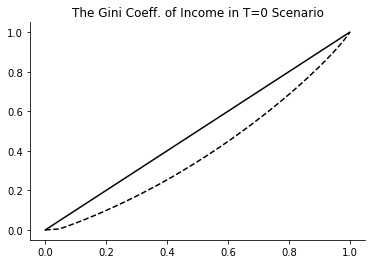

The Gini coefficient for income is 0.22201


In [25]:
# compute the Gini Coeff. for income
# step 1: compute the income and weight(sum up to 1)
income_range=pd.Series(income.reshape(1,income.shape[0]*income.shape[1])[0]).unique()
weight=np.array([joint_pdf[income==ii].sum() for ii in income_range])
income_range=np.append([0],income_range)
weight=np.append([0],weight)
# step 2: sort by income, ascending
# step 3: compute the accumulative weight sum 
weight_cumsum=weight.cumsum()
# step 4: compute the accumulative income sum 
income_sum_array=income_range*weight
income_cumsum=income_sum_array.cumsum()
income_cumsum=income_cumsum/sum(income_sum_array)
# step 5: calculate the Gini coefficients
weight_diff=weight_cumsum[1:]-weight_cumsum[0:-1]
gini_diff=weight_cumsum-income_cumsum
Gini_income=sum(gini_diff[1:]*weight_diff)  # gini_coeff will be overestimated if gini_diff[1:]

fig, ax = plt.subplots(1, 1,figsize=(6, 4))
ax.plot(weight_cumsum,weight_cumsum,'k-')
ax.plot(weight_cumsum,income_cumsum,'k--')
ax.set_title('The Gini Coeff. of Income in T=0 Scenario')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()
#fig.savefig('The Gini Coeff. of Income in T=0 Scenario.pdf')

print('The Gini coefficient for income is %.5f'%(2*Gini_income))

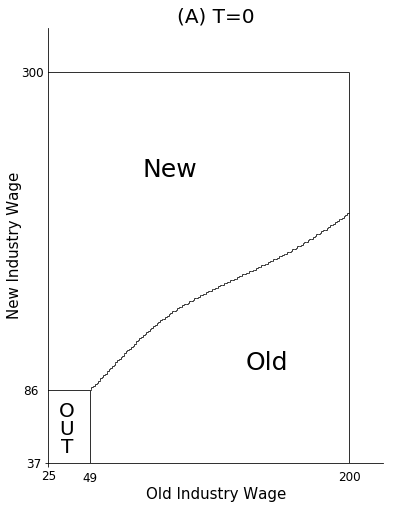

In [27]:
# draw the decision graph
#https://blog.csdn.net/weixin_41743584/article/details/99855902

fig1 = plt.figure(figsize=(6, 8))
ax = plt.axes()

plt.xlim(25,220)
plt.ylim(37,330)

#draw the range
plt.hlines(300, 0, 200, colors='k', linestyle="-",linewidth=0.8)
plt.vlines(200, 0, 300, colors='k', linestyle="-",linewidth=0.8)

# draw the reservation area
plt.hlines(86, 0, 49, colors='k', linestyle="-",linewidth=0.8)
plt.vlines(49, 0, 86, colors='k', linestyle="-",linewidth=0.8)

#draw the old-new boundary
for ii in range(decision.shape[0]):
    for jj in range(decision.shape[1]-1):
        if decision.iloc[ii,jj]==0 and decision.iloc[ii,jj+1]==1:
            plt.vlines(jj+25, ii+37,ii+38, colors='k', linestyle="-",linewidth=0.8)

for jj in range(decision.shape[1]):
    for ii in range(decision.shape[0]-1):
        if decision.iloc[ii,jj]==1 and decision.iloc[ii+1,jj]==0:
            plt.hlines(ii+38, jj+24,jj+25, colors='k', linestyle="-",linewidth=0.8)

#label the number and decision
plt.text(10, 83, "86",fontsize=12)
plt.text(9, 297, "300",fontsize=12)
plt.text(45, 24, "49",fontsize=12)
plt.text(194, 25, "200",fontsize=12)
plt.text(31,68,'O',fontsize=20)
plt.text(31.5,56,'U',fontsize=20)
plt.text(32.5,44,'T',fontsize=20)
plt.text(140,100,'Old',fontsize=25)
plt.text(80,230,'New',fontsize=25)
#plt.text(80,15,'Old Industry Wage',fontsize=12)


#set axis notation
plt.xticks(np.linspace(25,250,1),fontsize=12)
plt.yticks(np.linspace(37,350,1),fontsize=12)

plt.xlabel('Old Industry Wage',fontsize=15)
plt.ylabel('New Industry Wage',fontsize=15)
plt.title('(A) T=0',fontsize=20)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()
fig1.savefig('Labor Participation Choice in T=0 Scenario.pdf')